# Final Project
### DTSA 5510 - Unsupervised Machine Learning, as part of the MS-DS program
#### University of Colorado, Boulder
##### October 2024


## Introduction

For this project, I will be working with the Wine dataset from the University of California, Irvine. I will be using a few different clustering methods on the dataset and tuning some hyperparameters to optimize classification accuracy.

I chose this dataset because I personally enjoy drinking wine and pairing it with food. While this is a simple clustering project, a lot can be done with machine learning for food and drink recommender systems. A quick internet search brings up several different projects, both small and large. As this is my first course in unsupervised learning, I'll start with something basic.

### The data

The data was accessed from the [University of California at Irvine repository](https://archive.ics.uci.edu/dataset/109/wine).

It is available under the [Creative Commons License](https://creativecommons.org/licenses/by/4.0/legalcode).

A short blurb about the data from the website from which it was accessed:
* "These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines."
* "In a classification context, this is a well posed problem with "well behaved" class structures. (This is) a good data set for first testing of a new classifier, but not very challenging."

##### Data features, all of which are numerical:
* Alcohol: Alcohol content by volume
* Malicacid: Organic compound in grapes that contributes to the sour taste of fruit, makes the wine acidic.
* Ash: According to the [International Organization of Vine and Wine](https://www.oiv.int/standards/compendium-of-international-methods-of-wine-and-must-analysis/annex-a-methods-of-analysis-of-wines-and-musts/section-2-physical-analysis/ash-%28type-i%29), the ash content is defined as "all those products remaining after igniting the residue left after the evaporation of the wine. The ignition is carried out in such a way that all the cations (excluding the ammonium cation) are converted into carbonates or other anhydrous inorganic salts." So it's a bi-product of the chemical analysis process, not an ingredient!
* Alcalinity-of-ash: pH of the above.
* Magnesium: A mineral naturally occurring in grapes
* Total_phenols: [US National Libary of Medicine](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7866523/) describes polyphenols as phenolic compounds which contribute to the colour, flavour, and taste of wine.
* Flavanoids: A subgroup of polyphenols
* Nonflavanoid_phenols: Another subgroup of polyphenols
* Proanthocyanins: Principal phenols in red wine
* Color-intensity: Strength of colour
* Hue: The colour of the wine
* 0D280_0D315_of_diluted_wines
* Proline: Naturally occuring amino acid

##### Target data, or ground-truth labels
* The dataset contains observations which are all one of 3 different cultivars. I'll use these labels to assess how accurate my clustering model works.

### Methods

First, I imported the necessary packages:

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN

I accessed the data directly from the online repository:

In [2]:
# !pip install ucimlrepo  ## uncomment to install required repository
from ucimlrepo import fetch_ucirepo

In [3]:
# read in data
wine = fetch_ucirepo(id=109)
# wine # calling the wine object displays meta data


### EDA

Next I took a look at the data to see if there were any readily apparent patterns:

In [4]:
X = wine.data.features
y = wine.data.targets

X.head(3)

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       178 non-null    float64
 1   Malicacid                     178 non-null    float64
 2   Ash                           178 non-null    float64
 3   Alcalinity_of_ash             178 non-null    float64
 4   Magnesium                     178 non-null    int64  
 5   Total_phenols                 178 non-null    float64
 6   Flavanoids                    178 non-null    float64
 7   Nonflavanoid_phenols          178 non-null    float64
 8   Proanthocyanins               178 non-null    float64
 9   Color_intensity               178 non-null    float64
 10  Hue                           178 non-null    float64
 11  0D280_0D315_of_diluted_wines  178 non-null    float64
 12  Proline                       178 non-null    int64  
dtypes: fl

There are no missing values in the dataset, and all features appear to be of the correct datatype.

I created some visualizations for each feature:

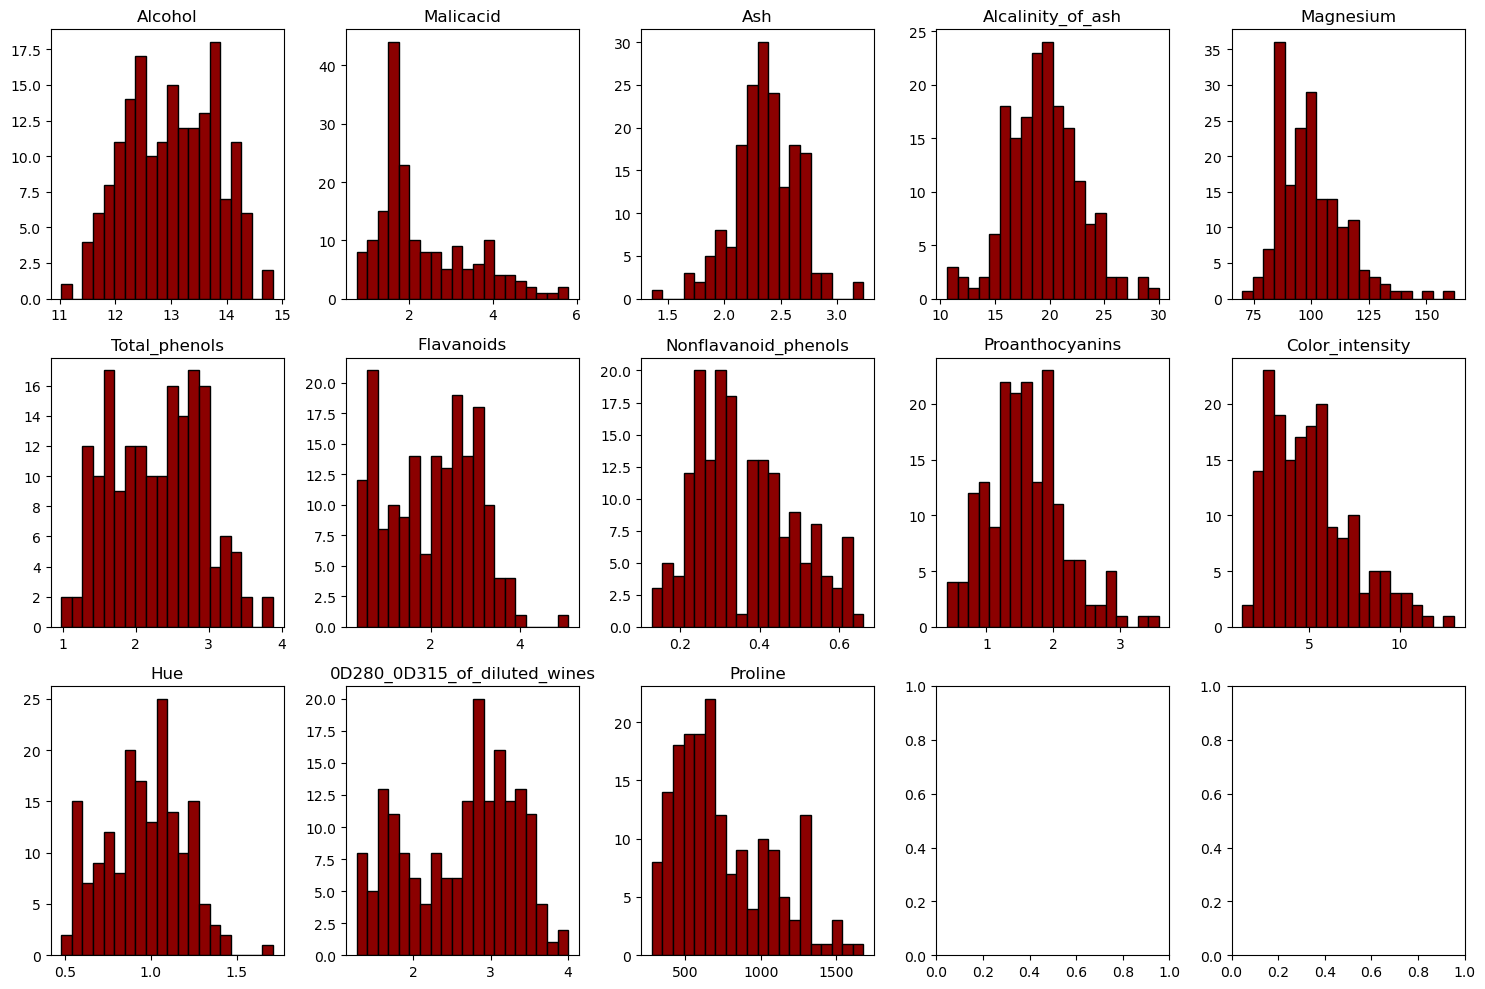

In [6]:
# 3 by 5 grid for plots
fig, axes = plt.subplots(3, 5, figsize=(15, 10))

# flatten for easy iteration
axes = axes.ravel()

# histograms for each feature
for i, col in enumerate(X.columns):
    axes[i].hist(X[col], bins=20, color='darkred', edgecolor='black')
    axes[i].set_title(col)

# layout
plt.tight_layout()
plt.show()

In [7]:
class_proportions = y.value_counts() / len(y)
class_proportions

class
2        0.398876
1        0.331461
3        0.269663
Name: count, dtype: float64

At this point, nothing in the features stood out to me as showing a pattern. The target class is a bit imbalanced, however. I will consider this imbalance further on. 

Time to move on to clustering!

### KMeans Clustering

The first type of clustering I did was KMeans. Because I know there are 3 types of cultivars, I set n_clusters to 3:

In [8]:
kmeans = (KMeans(n_clusters = 3,
                 max_iter = 300,
                 random_state = 5510)
         )

kmeans.fit(X)

# cluster labels
labels = kmeans.labels_
X['kmeans_cluster'] = labels

#### Evaluation of KMeans 

One method of evaluation is ARI. Values range from -1 to 1, with 1 being a perfect fit.

In [9]:
# reshape y to 1D array 
y_true = y.values.ravel() 
ari = adjusted_rand_score(y_true, labels)
print(f'Adjusted Rand Index (ARI): {ari:.4f}')

Adjusted Rand Index (ARI): 0.3711


Another evaluation method is AMI. Values range from 0 to 1

In [10]:
ami = adjusted_mutual_info_score(y_true, labels, average_method='arithmetic')
print(f'Adjusted Mutual Information (AMI): {ami:.4f}')

Adjusted Mutual Information (AMI): 0.4227


More evaluation... (needs explanation)

In [11]:
homogeneity = homogeneity_score(y_true, labels)
completeness = completeness_score(y_true, labels)
v_measure = v_measure_score(y_true, labels)
print(f'Homogeneity: {homogeneity:.4f}')
print(f'Completeness: {completeness:.4f}')
print(f'V-Measure: {v_measure:.4f}')

Homogeneity: 0.4288
Completeness: 0.4287
V-Measure: 0.4288


In [17]:
# normalize 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

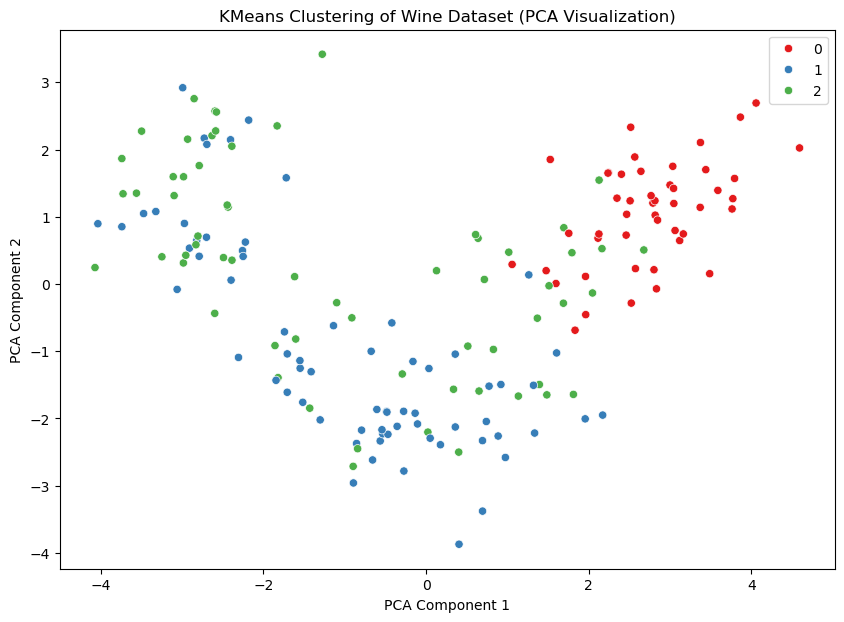

In [20]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set1', legend='full')
plt.title('KMeans Clustering of Wine Dataset (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

These metrics show that kmeans isn't the greatest for this dataset. I tried some more methods to see if there was another that works better.

### Hierarchical Clustering

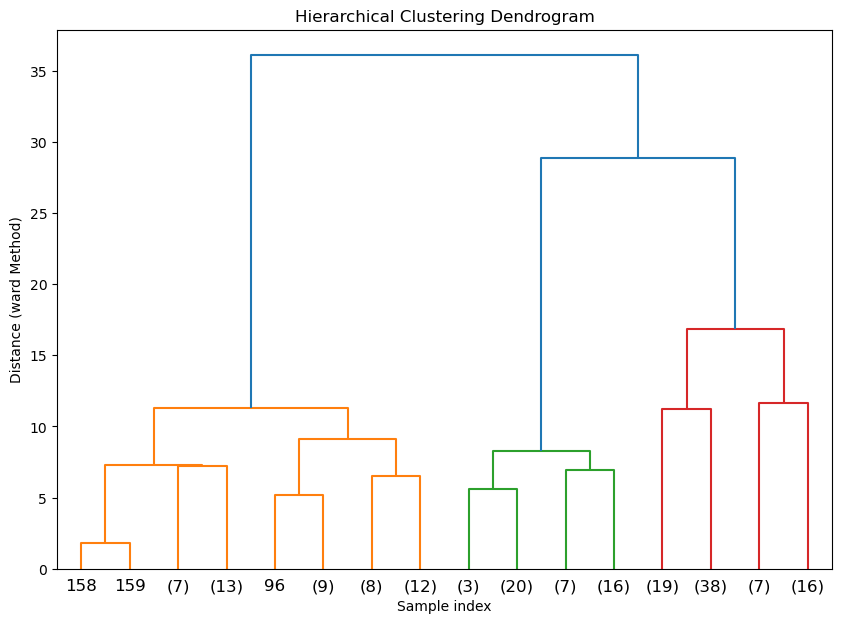

Adjusted Rand Index (ARI) for ward method: 0.7288
Adjusted Mutual Information (AMI) for ward method: 0.7467


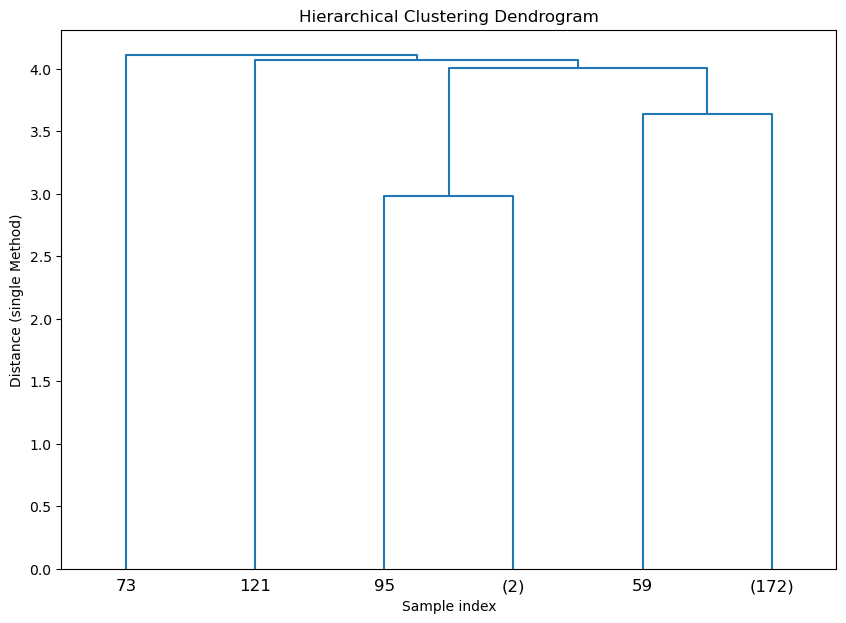

Adjusted Rand Index (ARI) for single method: -0.0038
Adjusted Mutual Information (AMI) for single method: -0.0033


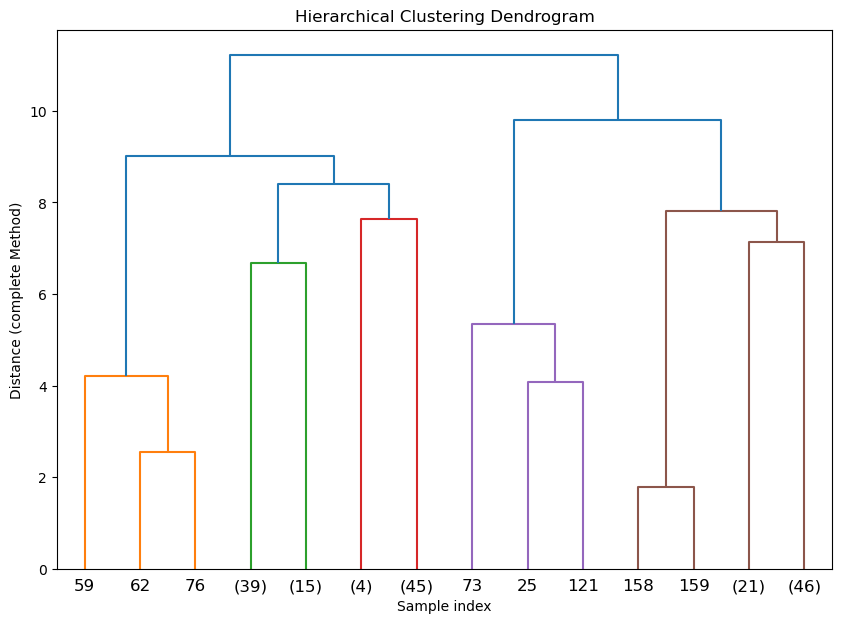

Adjusted Rand Index (ARI) for complete method: 0.3664
Adjusted Mutual Information (AMI) for complete method: 0.4588


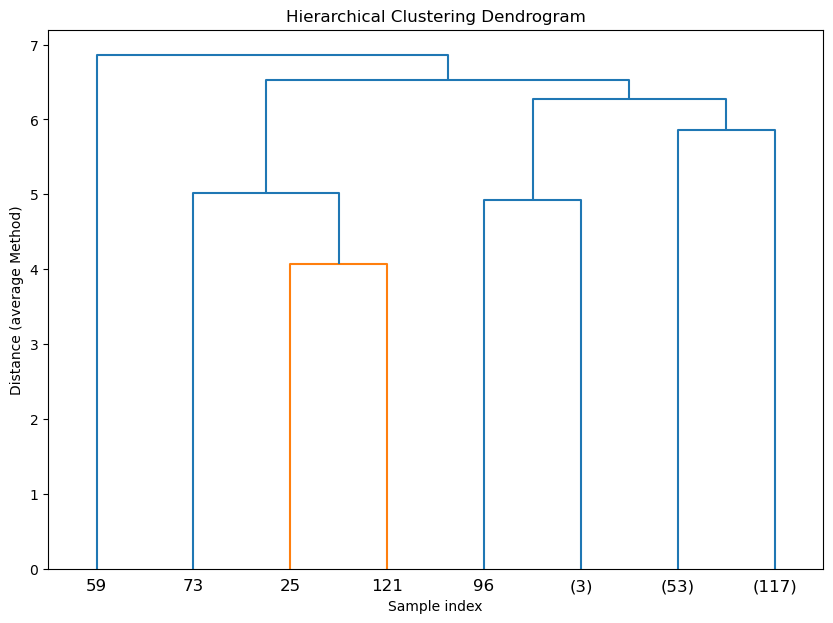

Adjusted Rand Index (ARI) for average method: -0.0054
Adjusted Mutual Information (AMI) for average method: -0.0038


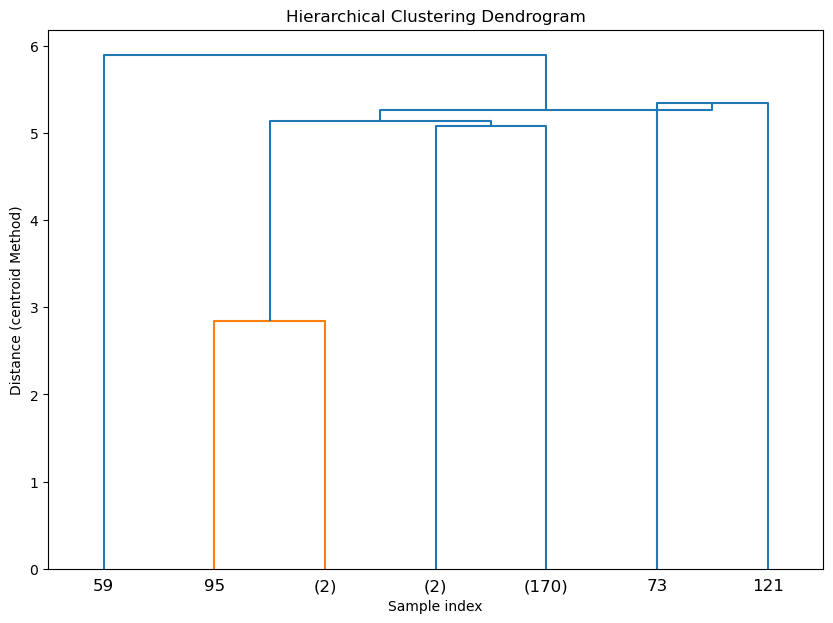

Adjusted Rand Index (ARI) for centroid method: -0.0020
Adjusted Mutual Information (AMI) for centroid method: -0.0017


In [26]:
# linkage methods
methods = ['ward', 'single', 'complete', 'average', 'centroid']
ari_scores = []
ami_scores = []

# loop through methods, plot and evaluate
for method in methods:
    Z = linkage(X_scaled, method = method)

    # extract cluster labels
    cluster_labels = fcluster(Z, t = 3, criterion = 'maxclust') 

    # calculate ari and ami scores
    ari = adjusted_rand_score(y_true, cluster_labels)
    ari_scores.append(ari)
    ami = adjusted_mutual_info_score(y_true, cluster_labels)
    ami_scores.append(ami)
    
    # plot dendrogram
    plt.figure(figsize = (10, 7))
    dendrogram(Z, truncate_mode = 'level', p = 3)  
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample index')
    plt.ylabel(f'Distance ({method} Method)')
    plt.show()

    # print scores
    print(f'Adjusted Rand Index (ARI) for {method} method: {ari:.4f}')
    print(f'Adjusted Mutual Information (AMI) for {method} method: {ami:.4f}')

The ward method in hierarchical clustering results in the highest scores. The 'complete' method wasn't bad. The average and centroid method were not good at all.

In [27]:
# add cluster labels to X df
Z = linkage(X, method='ward', metric='euclidean')
cluster_labels = fcluster(Z, t=3, criterion='maxclust')

X['hier_cluster'] = cluster_labels

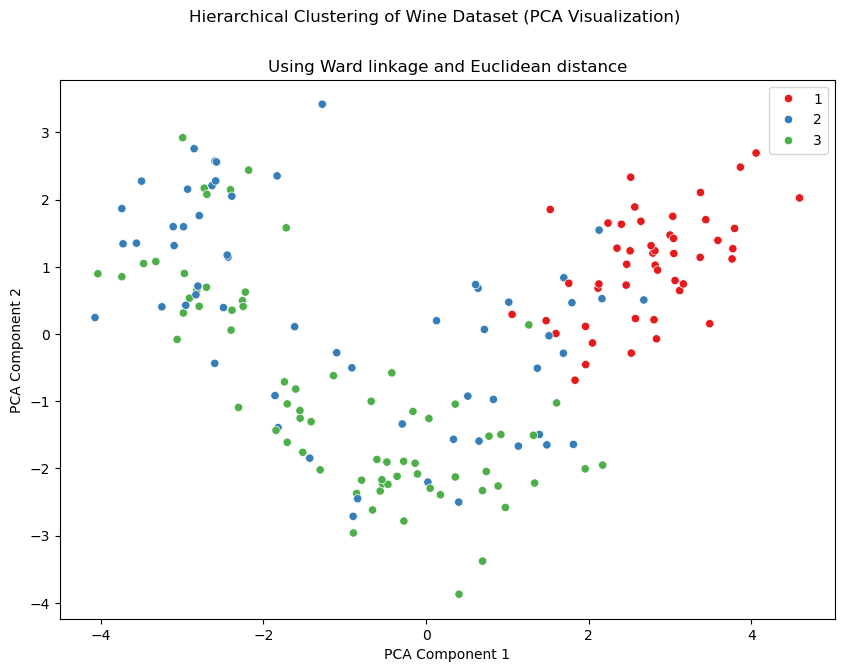

In [22]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='Set1', legend='full')
plt.suptitle('Hierarchical Clustering of Wine Dataset (PCA Visualization)')
plt.title('Using Ward linkage and Euclidean distance')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

### Agglomerative Clustering

In [23]:
# linkages and distances
methods = ['ward', 'complete', 'average', 'single']
distance_metrics = ['euclidean', 'manhattan', 'cosine']  

# store results
results = []

# loop through linkages and distances
for method in methods:
    for metric in distance_metrics:
        # ward linkage requirs euclidean dist
        if linkage == 'ward' and metric != 'euclidean':
            continue
        
        # agglom clustering
        agg_clustering = (AgglomerativeClustering(n_clusters = 3, 
                                                  metric = metric, 
                                                  linkage = method))
        
        try:
            clusters = agg_clustering.fit_predict(X_scaled)

            # calculate ari and ami scores
            ari_score = adjusted_rand_score(y_true, clusters)
            ami_score = adjusted_mutual_info_score(y_true, clusters)
            results.append((method, metric, ari_score, ami_score))
            print(f"Linkage: {method}, Metric: {metric}, ARI: {ari_score:.4f}, AMI: {ami_score:.4f}")
        
        except Exception as e:
            print(f"Error with Linkage: {method}, Metric: {metric}: {str(e)}")

# best combination based on ari and ami
best_ari_combination = max(results, key=lambda x: x[2])
best_ami_combination = max(results, key=lambda x: x[3])

Linkage: ward, Metric: euclidean, ARI: 0.7288, AMI: 0.7467
Error with Linkage: ward, Metric: manhattan: manhattan was provided as metric. Ward can only work with euclidean distances.
Error with Linkage: ward, Metric: cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Linkage: complete, Metric: euclidean, ARI: 0.3664, AMI: 0.4588
Linkage: complete, Metric: manhattan, ARI: 0.6159, AMI: 0.6934
Linkage: complete, Metric: cosine, ARI: 0.6724, AMI: 0.7074
Linkage: average, Metric: euclidean, ARI: -0.0054, AMI: -0.0038
Linkage: average, Metric: manhattan, ARI: 0.4632, AMI: 0.5466
Linkage: average, Metric: cosine, ARI: 0.8835, AMI: 0.8505
Linkage: single, Metric: euclidean, ARI: -0.0038, AMI: -0.0033
Linkage: single, Metric: manhattan, ARI: -0.0038, AMI: -0.0033
Linkage: single, Metric: cosine, ARI: -0.0068, AMI: 0.0130


Best: Average linkage and cosine distance

Ward linkage and euclidean distance is second
not bad - complete linkage overall wasnt bad
average linkage had a surprising range of scores. Interesting.
single linkage - not good at all

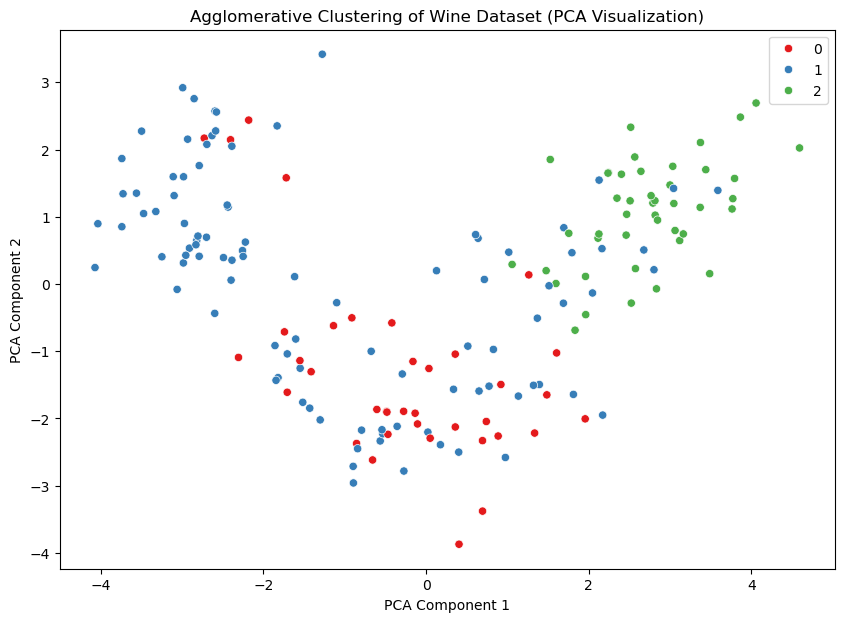

In [29]:
agg_clustering = (AgglomerativeClustering(n_clusters = 3, 
                                                  metric = 'cosine', 
                                                  linkage = 'average'))

agg_clustering.fit(X)

# cluster labels
labels = agg_clustering.labels_
X['agg_cluster'] = labels

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set1', legend='full')
plt.title('Agglomerative Clustering of Wine Dataset (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

### DBSCAN clustering

In [ ]:
dbscan = DBSCAN(eps = 1.5, min_samples = 6)  
clusters = dbscan.fit_predict(X_scaled)

# Add the cluster labels to the original DataFrame
X['dbscan_cluster'] = clusters

# 4. Evaluate and visualize the clusters
# Count of points in each cluster (including noise labeled as -1)
cluster_counts = pd.Series(clusters).value_counts()

print("Cluster Counts:")
print(cluster_counts)

from sklearn.decomposition import PCA

# Perform PCA to reduce dimensions for visualization
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)

# Create a scatter plot of the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='Set1', legend='full')
plt.title('DBSCAN Clustering of Wine Dataset')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [ ]:
X.head()


An unsupervised machine learning clustering project generally involves several key components or steps. Here’s a breakdown of the main stages:

1. Problem Definition and Objective Setting
Goal: Define the purpose of the clustering project. Common objectives include grouping similar items, customer segmentation, anomaly detection, etc.
Data Understanding: Gain an initial understanding of the data, the domain, and the expected outcome of clustering.
2. Data Collection
Collect or access the data to be clustered. This data could come from databases, web scraping, APIs, or predefined datasets.
3. Data Preprocessing and Cleaning
Handling Missing Values: Decide how to handle missing data (removal, imputation, etc.).
Dealing with Outliers: Identify and either remove or treat outliers.
Scaling and Normalization: Apply techniques like standardization (z-score normalization) or min-max scaling to bring all features to the same scale.
Encoding Categorical Variables: Convert categorical data into numerical form (e.g., one-hot encoding, label encoding).
Feature Selection: Choose relevant features based on their importance, domain knowledge, or statistical tests.
Dimensionality Reduction: Apply techniques like PCA or t-SNE to reduce the dimensionality of the data, if necessary.
4. Exploratory Data Analysis (EDA)
Visualize the data using histograms, scatter plots, and pair plots to understand its structure.
Check for relationships or patterns among features.
Use techniques like correlation matrices or summary statistics to assess the distribution and relationships.
5. Choosing a Clustering Algorithm
The choice of algorithm depends on the nature of the data and the project objective. Common clustering algorithms include:

* K-Means: Suitable for spherical clusters and requires specifying the number of clusters.
* Hierarchical Clustering: Builds a hierarchy of clusters and doesn't require pre-specifying the number of clusters.
* DBSCAN (Density-Based Spatial Clustering): Suitable for identifying clusters of arbitrary shapes, including noise.
* Gaussian Mixture Models (GMM): Assumes that data points are generated from a mixture of several Gaussian distributions.
* Agglomerative Clustering: A type of hierarchical clustering that can handle various linkage criteria.

6. Model Training (Clustering)
Initialization: Set up the clustering algorithm with relevant hyperparameters (e.g., number of clusters in K-Means, distance metric, etc.).
Fitting the Model: Apply the clustering algorithm to your dataset to assign data points to clusters.
7. Cluster Evaluation
Clustering is unsupervised, so evaluation can be tricky. Here are some evaluation methods:

Internal Evaluation Metrics (when ground truth is not available):
Silhouette Score: Measures how similar each point is to its cluster compared to other clusters.
Inertia (K-Means): Measures how tight the clusters are.
Davies-Bouldin Index: Evaluates the ratio of within-cluster scatter to between-cluster separation.


External Evaluation Metrics (if ground truth labels are available):
* Adjusted Rand Index (ARI): Measures how well the clustering matches ground truth labels.
* Normalized Mutual Information (NMI): Measures the similarity between predicted clusters and ground truth labels.
* Elbow Method: Used in K-Means to determine the optimal number of clusters by plotting within-cluster sum of squares.


8. Visualization of Clusters
Scatter Plots or Pair Plots: Visualize clusters in 2D or 3D.
t-SNE or PCA: Visualize high-dimensional clusters in lower dimensions.
Dendrograms: Used in hierarchical clustering to visualize the hierarchy of clusters.
Heatmaps: Used to visualize relationships within clusters, especially with hierarchical clustering.
9. Model Interpretation and Insights
Cluster Profiling: Examine the characteristics of each cluster by comparing feature means, distributions, etc.
Business Interpretation: Relate clusters back to the business objective or problem you're solving.
Anomaly Detection: Clustering can help identify outliers that don’t fit into any cluster.
10. Hyperparameter Tuning
Experiment with different values for hyperparameters (e.g., number of clusters, distance metrics) to improve the clustering.
Use grid search or random search for hyperparameter optimization.
11. Deployment (if necessary)
Integrate the clustering model into production systems if needed (e.g., customer segmentation in a marketing system).
Monitor and Update: Clustering models might require updates as new data comes in.
12. Reporting and Communication
Visualization: Provide visual representations of clusters for better understanding.
Report: Summarize the findings, describe the characteristics of the clusters, and present actionable insights to stakeholders.
Documentation: Ensure that all steps, assumptions, and decisions made during the project are documented.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Perform Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=3, metric='cosine', linkage='average')
clusters = agg_clustering.fit_predict(X_scaled)

# Add the cluster labels to the original DataFrame
X['agg_cluster'] = clusters



